# Modelling and Evaluation

## Goal

The purpose of this notebook is to build two classification models on training data and generate predictions on the data in test.csv using each of trained models. 

The exercise_40_train.csv data is going to be training dataset of this study and the exercise_40_test.csv data is going to be test (out of sample) dataset of two main models.

The outcome variable is "y". It has two classes as 1 and 0.

Logistic Regression, and Neural Network are the models used for this assignment.


## Data Description

The dataset of this section contains 7052 observations along with 80 columns after cleaning steps placed in  the EDA & Data Cleaning notebook.


## Code and Results

End of the each section and in the middle of the code blocks you will encounter the main/intermadiate findings of the study as brief comments.

The "glmresults.csv" file contains the prediction results obtained from Logistic Regression.

The "nonglmresults.csv" file contains the prediction results obtained from Neural Network model.


In [1]:
#Load Libraries

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import savetxt

# Visuallization 
import matplotlib.pyplot as plt

# Neural Network
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers


# For the model
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# Feature-engine
from feature_engine.encoding import OneHotEncoder
from feature_engine.imputation import CategoricalImputer
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from feature_engine.transformation import YeoJohnsonTransformer


# Neural Network
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers


# Imbalance Issue
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
)
from imblearn.datasets import fetch_datasets
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import (
    BalancedBaggingClassifier,
    BalancedRandomForestClassifier,
    RUSBoostClassifier,
    EasyEnsembleClassifier,
)
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import (
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    AllKNN
)

2023-02-23 14:19:15.802534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Collection

In [2]:
# upload the cleaned training.csv data

data=pd.read_csv('cleaned_train.csv')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,y,x59,x79,x98,x24,x31,x60,x65,x77,x93,...,transformed_x89,transformed_x91,transformed_x92,transformed_x94,transformed_x95,transformed_x96,transformed_x97,transformed_x100,transformed_cleaned_x7,transformed_cleaned_x19
0,0,0,1.0,0,male,yes,January,farmers,Missing,no,...,2.265617,-0.512431,1.846892,3.124327,-0.112767,1.288350,6.328536,78.671733,-0.010583,32.806694
1,1,0,1.0,0,male,no,Rare,progressive,Missing,no,...,2.331022,0.923933,1.019922,3.213619,-0.363654,1.230329,6.844704,80.518567,-0.005196,1396.706508
2,0,1,1.0,1,male,no,August,allstate,nissan,no,...,2.074972,-2.549789,4.190514,3.394245,-2.041487,1.252407,9.936736,70.378750,-0.001400,-900.175793
3,0,0,1.0,1,male,no,Rare,esurance,ford,no,...,2.518079,0.150573,-1.544330,3.184899,0.242155,1.218931,9.003309,72.656706,-0.008589,-423.215044
4,1,0,1.0,0,male,no,August,allstate,nissan,no,...,2.081187,1.604100,1.323545,1.839678,0.619195,1.252318,6.167408,80.090052,0.002301,-26.625252


In [3]:
# Data shape
print(f'Number of observations: {data.shape[0]} ')
print(f'Number of features: {data.shape[1]} \n')

# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and data[var].nunique()<3 and var != 'y']
continuous = [var for var in data.columns if data[var].dtype!='O' and var not in discrete and var != 'y' ]
target=data['y']

# categorical
categorical = [var for var in data.columns if data[var].dtype=='O' and var != 'y' ]

print('Target variable: {}'.format('y'))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))

Number of observations: 7052 
Number of features: 80 

Target variable: y
There are 3 discrete variables
There are 68 continuous variables
There are 8 categorical variables


## Preprocessing

The highlight here is that I apply one hot encoding, undersampling, feature scaling, and feature selection steps __right after train-test split__. The main reason to do that is avoiding overfitting.
<br> In addition, I will implement undersampling on train SET ONLY !

### Train - Test Split

In [4]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
                                                      data.drop("y", axis=1),  # predictors
                                                      data["y"],               # target
                                                      test_size=0.2,           # percentage of obs in test set
                                                      random_state=0,
                                                    )  

X_train.shape, X_test.shape

((5641, 79), (1411, 79))

### Categorical Encoding

In [5]:
# casting discrete variables to categorical variable

data[discrete]=data[discrete].astype('O')

In [6]:
pipe_enc = Pipeline([

                    ('ohe', ce.OneHotEncoder( 
                                              drop_last=True))

])

In [7]:
# fit pipeline

pipe_enc.fit(X_train)

Pipeline(steps=[('ohe', OneHotEncoder(drop_last=True))])

In [8]:
# transform data

X_train_enc = pipe_enc.transform(X_train)
X_test_enc = pipe_enc.transform(X_test)

X_train_enc

,x59,x79,x98,transformed_x1,transformed_x4,transformed_x5,transformed_x6,transformed_x8,transformed_x9,transformed_x10,...,cleaned_x3_Wednesday,cleaned_x3_Saturday,cleaned_x3_Tuesday,cleaned_x3_Friday,cleaned_x3_Sunday,cleaned_x33_Midwest,cleaned_x33_Missing,cleaned_x33_Northeast,cleaned_x33_South,cleaned_x33_Southwest
1891,0,0.0,0,1.975301,-1.855417,1.181794,0.267337,0.838011,1.332696,-0.897682,...,0,0,0,0,0,1,0,0,0,0
3055,0,1.0,0,2.843902,-1.497030,1.495477,-0.811803,2.607994,2.757972,0.291428,...,1,0,0,0,0,0,1,0,0,0
5135,1,1.0,0,1.805649,-1.173456,0.566603,0.584945,0.900835,1.812861,0.297323,...,0,0,0,0,0,1,0,0,0,0
2359,0,1.0,1,4.787096,0.567696,-0.186570,-0.859806,-0.678377,2.586730,-1.200551,...,0,1,0,0,0,0,0,1,0,0
3010,0,1.0,1,1.285235,0.034459,0.277515,-2.070515,0.050910,3.907809,-1.724578,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,0,1.0,1,0.329919,0.555338,-0.844207,0.354229,-2.498379,1.155290,1.746155,...,0,1,0,0,0,0,0,0,0,0
3264,0,1.0,1,2.897882,0.786824,-1.025898,-0.376717,2.274404,2.141955,0.917719,...,0,0,1,0,0,0,0,0,1,0
1653,0,1.0,1,2.027183,2.017322,-1.195349,1.004555,-0.465451,1.346698,-0.381936,...,0,0,0,1,0,0,1,0,0,0
2607,1,1.0,0,2.527560,0.531990,0.449760,0.431112,-0.010908,0.282032,-0.885033,...,0,1,0,0,0,1,0,0,0,0


### Undersampling

In [9]:
# class to perform under-sampling based on the condensed nearest neighbour method.

renn = RepeatedEditedNearestNeighbours(
                                        sampling_strategy='auto',# removes only the majority class
                                        n_neighbors=5, # the number of neighbours to examine
                                        kind_sel='all', # all neighbouring observations should show the same class
                                        n_jobs=8, # 4 processors in my laptop
                                        max_iter=100) # maximum number of iterations

X_resampled, y_resampled = renn.fit_resample(X_train_enc, y_train)

In [10]:
# size of undersampled data

X_resampled.shape, y_resampled.shape

((1779, 100), (1779,))

In [11]:
# number of minority class before & after undersampling

print('Number of 1-0 classes before undersampling: \n',y_train.value_counts(),'\n')
print('Number of 1-0 classes after  undersampling: \n', y_resampled.value_counts())

Number of 1-0 classes before undersampling: 
 0    4768
1     873
Name: y, dtype: int64 

Number of 1-0 classes after  undersampling: 
 0    906
1    873
Name: y, dtype: int64


### Feature Scaling

In [12]:
# logistic model benefit from feature scaling

scaler = StandardScaler()
scaler.fit(X_resampled)

StandardScaler()

In [13]:
# transform train and test sets

X_train_scaled = scaler.transform(X_resampled)
X_test_scaled = scaler.transform(X_test_enc)

In [14]:
# since scaling returns a NumPy array, 
# i am capturing the feature names first and then convert the array to a dataframe.

X_train_features = scaler.fit_transform(X_resampled)
df_scaled_X_train = pd.DataFrame(X_train_features, index=X_resampled.index, columns=X_resampled.columns)

X_test_features = scaler.fit_transform(X_test_enc)
df_scaled_X_test = pd.DataFrame(X_test_features, index=X_test_enc.index, columns=X_test_enc.columns)

X_train_features

array([[ 3.11718903,  0.34067613, -1.01529401, ..., -0.40905114,
        -0.55245733, -0.29789141],
       [-0.32080185,  0.34067613,  0.98493638, ..., -0.40905114,
        -0.55245733,  3.35692799],
       [-0.32080185,  0.34067613, -1.01529401, ...,  2.4446821 ,
        -0.55245733, -0.29789141],
       ...,
       [ 3.11718903,  0.34067613, -1.01529401, ..., -0.40905114,
        -0.55245733, -0.29789141],
       [-0.32080185,  0.34067613, -1.01529401, ..., -0.40905114,
        -0.55245733, -0.29789141],
       [-0.32080185,  0.34067613,  0.98493638, ..., -0.40905114,
        -0.55245733, -0.29789141]])

## Modelling

### 1. Feature Selection & Logistic Regression

This part, i will use lasso regression to remove non-essential features from the dataset.

In [15]:
# feature selection and model fitting will be placed together within sel_ object.
# first I specify the Logistic Regression model, and I
# make sure I select the Lasso (l1) penalty.

# then I use the selectFromModel class from sklearn, which
# will select the features which coefficients are non-zero

sel_ = SelectFromModel(
                        LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_resampled)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [16]:
# a list with the selected features

selected_feats = df_scaled_X_train.columns[(sel_.get_support())]

print('total features: {}'.format((df_scaled_X_train.shape[1])))
print('selected features: {}'.format(len(selected_feats)))
print('features with coefficients shrank to zero: {}'.format(np.sum(sel_.estimator_.coef_ == 0)))

total features: 100
selected features: 93
features with coefficients shrank to zero: 7


In [17]:
# let's see the features that our model selected  & removed

removed_feats = df_scaled_X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
print('Removed features: ',removed_feats)

Removed features:  Index(['transformed_x16', 'transformed_x35', 'transformed_x49',
       'transformed_x52', 'transformed_x78', 'transformed_x97',
       'x65_esurance'],
      dtype='object')


In [18]:
# I am removing the features from the train and test set.

X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

X_train_selected.shape, X_test_selected.shape

((1779, 93), (1411, 93))

- Since SelectFromModel returns a NumPy array, i will capture the feature names first and then convert the array to a dataframe.

In [19]:
# fit model with selected features

lg_model = sel_.estimator_.fit(X_train_selected,y_resampled)

### 2. Evaluation of Logistic Regression

In [20]:
# Model performance metrics

print('Train set')
pred = lg_model.predict_proba(X_train_selected)
print(
       'Logistic Regression roc-auc: {}'.format(roc_auc_score(y_resampled, pred[:, 1])))


print('Test set')
pred = lg_model.predict_proba(X_test_selected)
print(
        'Logistic Regression roc-auc:: {}'.format(roc_auc_score(y_test, pred[:, 1])))

Train set
Logistic Regression roc-auc: 0.7820600350469948
Test set
Logistic Regression roc-auc:: 0.6745099343130952


In [21]:
# Predictions

y_pred=lg_model.predict(X_test_selected)

In [22]:
# Let's see precision, recall and f1-score along

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.65      0.75      1182
           1       0.24      0.59      0.35       229

    accuracy                           0.64      1411
   macro avg       0.57      0.62      0.55      1411
weighted avg       0.79      0.64      0.68      1411



- The model performs poorly on the training data. Let's see the ROC curve

- This is because the model is unable to capture the relationship between the target and predictors. This gives me a hint to what model I should pick up as second algorithm. To overcome this, we need to increase the complexity of the model and adding more features to the dataset. Then I will go with Neural Network.

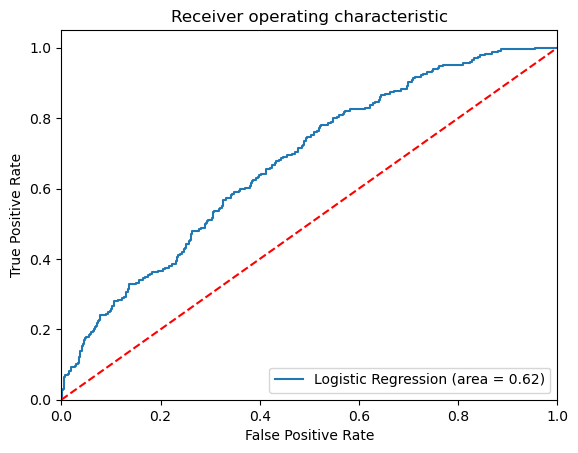

In [23]:
#ROC Curve

area_under_curve = roc_auc_score(y_test, lg_model.predict(X_test_selected))
fpr, tpr, thresholds = roc_curve(y_test, lg_model.predict_proba(X_test_selected)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % area_under_curve)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

- Since, the higher the AUC, the better the model’s performance at distinguishing between the positive and negative classes, logistic regression failed to achieve that. Let's generate predictions for test.csv and save them

### 3. Generate Predictions of Logistic Regression  

I have already apply the necessary data cleaning steps to the provided test.csv file earlier. Now, I am loading the cleaned dataset and continue with encodig, scaling processes

In [24]:
# Load formatted test.csv file (after applying same formattings as I did in training.csv)

oos_data = pd.read_csv('cleaned_test.csv')
oos_data = oos_data.loc[:, ~oos_data.columns.str.contains('^Unnamed')]

In [26]:
# categorical = [var for var in oos_data.columns if oos_data[var].dtype=='O' ]
# oos_data['x79']=oos_data['x79'].astype('float')

In [27]:
# oos_data[['x24',
#  'x31',
#  'x59',
#  'x60',
#  'x65',
#  'x77',
#  'x79',
#  'x93',
#  'x98',
#  'cleaned_x3',
#  'cleaned_x33']]

In [30]:
#  ohe 

X_oos_enc = pipe_enc.transform(oos_data)



# scaling

X_oos_scaled = scaler.transform(oos_enc)



# scaling in dataframe format

X_oos_features = scaler.fit_transform(X_oos_enc)
df_scaled_X_oos = pd.DataFrame(X_oos_features, index=X_oos_enc.index, columns=X_oos_enc.columns)
df_scaled_X_oos.drop(removed_feats,axis=1, inplace=True)



# feature engineering

X_test_selected = sel_.transform(df_scaled_X_oos.to_numpy())

In [31]:
# predict results

print('out of sample set')
pred = lg_model.predict_proba(X_test_selected)
print(pred[:, 1])

out of sample set
[0.29438956 0.22295481 0.68353015 ... 0.53162364 0.58265759 0.07308755]


In [32]:
# save to csv file

savetxt('glmresults.csv', pred[:, 1])

In [42]:
len(pred[:, 1])

10000

### 4. Neural Network

In [33]:
# Scaling the data

scaler = StandardScaler()
scaler.fit(X_train_enc)


# transform train and test sets

X_train_scaled = scaler.transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)

In [34]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential() 
model.add(Dense(8, activation='relu', input_dim=X_train_enc.shape[1]))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 808       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 817
Trainable params: 817
Non-trainable params: 0
_________________________________________________________________


2023-02-23 14:21:57.776174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [35]:
# Model Creation

hist = model.fit(X_train_scaled, y_train, 
                 validation_data=(X_test_scaled, y_test), 
                 epochs=10, 
                 batch_size=10, 
                 validation_split=0.2)

Epoch 1/10
565/565 [==============================] - 1s 628us/step - loss: 0.6063 - accuracy: 0.6958 - val_loss: 0.4495 - val_accuracy: 0.8306
Epoch 2/10
565/565 [==============================] - 0s 496us/step - loss: 0.4092 - accuracy: 0.8426 - val_loss: 0.4357 - val_accuracy: 0.8320
Epoch 3/10
565/565 [==============================] - 0s 496us/step - loss: 0.3867 - accuracy: 0.8465 - val_loss: 0.4337 - val_accuracy: 0.8342
Epoch 4/10
565/565 [==============================] - 0s 494us/step - loss: 0.3756 - accuracy: 0.8488 - val_loss: 0.4369 - val_accuracy: 0.8342
Epoch 5/10
565/565 [==============================] - 0s 492us/step - loss: 0.3672 - accuracy: 0.8522 - val_loss: 0.4364 - val_accuracy: 0.8278
Epoch 6/10
565/565 [==============================] - 0s 493us/step - loss: 0.3619 - accuracy: 0.8553 - val_loss: 0.4384 - val_accuracy: 0.8342
Epoch 7/10
565/565 [==============================] - 0s 492us/step - loss: 0.3566 - accuracy: 0.8537 - val_loss: 0.4396 - val_accuracy:

[]

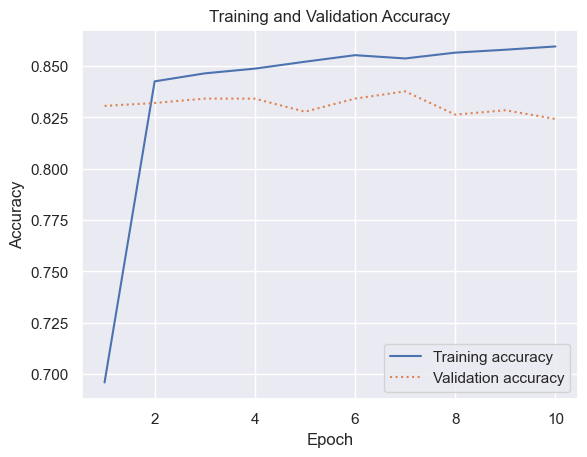

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

### 5. Evaluation of Neural Network

45/45 [==============================] - 0s 317us/step


Text(110.45000000000003, 0.5, 'Actual label')

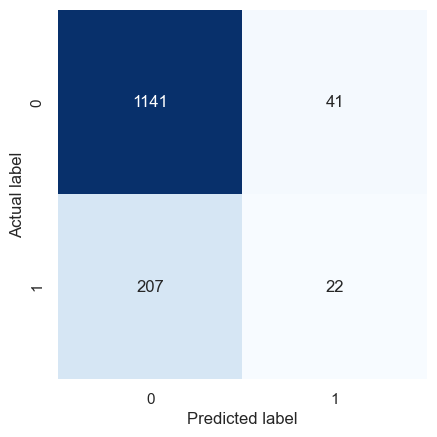

In [37]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(X_test_scaled) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['0', '1']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

### 6. Generate Predictions of Neural Network

In [38]:
y_oos_preds = model.predict(X_oos_scaled)
y_oos_preds

313/313 [==============================] - 0s 279us/step


array([[0.9999998],
       [0.9999994],
       [1.       ],
       ...,
       [1.       ],
       [1.       ],
       [0.9999999]], dtype=float32)

In [39]:
# save to csv file

savetxt('nonglmresults.csv', y_oos_preds)

## Summarization

- The first model of the study is Logistic Regression. The model performed poorly on the training data. Therefore it under fitted. While precision of class 0 is fairly doing good, however it failed on recall and f1 scores. It’s training roc score is  0.78 whereas testing roc score is 0.67. The one of the main reasons of under fitting is lack of the complexity in model. This is the weakness of the logistic regression we can state because logistic regression tends to underperform when there are multiple or non linear boundaries. They are not naturally enough mature to capture more complex relationships. However, logistic regression less likely to overfit compared to Neural Networks. That could be the strength of the logistic regression.

- The second model is only one layer of Neural Network, not that complicated. Since, logistic regression results showed the model is too simple, Neural Network was chosen as the second option. The model correctly identified 1138 transactions as class 0 while misclassifying class 0  44 times. This means class 0 classified correctly more than 96% of the time. Meanwhile the model caught only 13% of class 1 correctly. The neural network helped to improve the prediction of one class but not other. Therefore we can interpret that the data needs complexity but complexity does not fully address the problem here. That being said, we should go back to the data cleaning steps and grab new techniques especially for outliers engineering since most of the data was trimmed on that process. Aside from its tendency to overfitting, Neural Networks have the ability to learn by themselves to find the best features. I did not need to do much for feature selection on Neural Network.

- After, revisiting and choosing the appropriate data cleaning techniques that are suitable for this dataset along with selecting the right features (since logistic regression overfits in high dimensions and it needs to be given the right features by the developer) logistic regression could perform better.  
